In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-g3lw_1zd
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-g3lw_1zd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-a8lmaatl/pydoe_727c89f40b55497c8e6edeec14172e48
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-a8lmaatl/pydoe_727c89f40b55497c8e6edeec14172e48
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 316 kB 11.0 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145057 sha256=be6d430544405a0fe47cdcabbc2a719019b3300ce190a08f95cc2a327cc3a0fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from scipy.stats.qmc import Sobol, Halton

from benchmark.bbobbenchmarks import F21, F16

from tqdm.notebook import tqdm, trange

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
n_samples = 30000
samples = space.sample(n_samples)

obj_func = F21(1)

doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)
values = obj_func(samples)

n_runs = 100

In [13]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s')


# plot initial points provided to the CMA-ES and DoE, found by it, on the surface of the function
def plot_initial_found(func, samples, values, initial, found, result):
  fig, axs = plt.subplots(1, 2)
  fig.suptitle("Objective function " + func.__class__.__name__, fontsize=8)
  plot(samples, values, ax=axs[0], outline=False) # plot surface
  axs[0].set_title('Initial individual for CMA-ES')
  plot(samples, values, ax=axs[1], outline=False)
  axs[1].set_title('DoE found by CMA-ES')
  plot(initial, ["blue"] * initial.shape[0], ax=axs[0], outline=False)
  plot(found, ["yellow"] * initial.shape[0], ax=axs[1], outline=False)
  plt.show()


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30):
  plt.suptitle("BO history", fontsize=8)
  plot(samples, values, ax=plt.gca(), outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=plt.gca(), marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      plt.scatter(x, y, color="magenta", s=marker_size)
      plt.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=plt.gca(), marker='s', marker_size=marker_size)

In [7]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_all(doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in range(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

def compute_all_for(f, n=10):
  precisions, regrets, history = [], [], []
  for _ in trange(n):
    doe = f()
    r, p, h = compute_all(doe, n=1, n_points=1000)
    precisions.append(p)
    regrets.append(r)
    history.append(h[0])
  return precisions, regrets, history

# Latin hypercube sampling


In [5]:
def generate_lhs():
  return lhs(2, doe_size) * 10 - 5

In [ ]:
lhs_precision, lhs_regret, lhs_history = compute_all_for(generate_lhs, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

LHS precision: [3061.4499831444073], LHS regret: [6.66007355931697e-06]


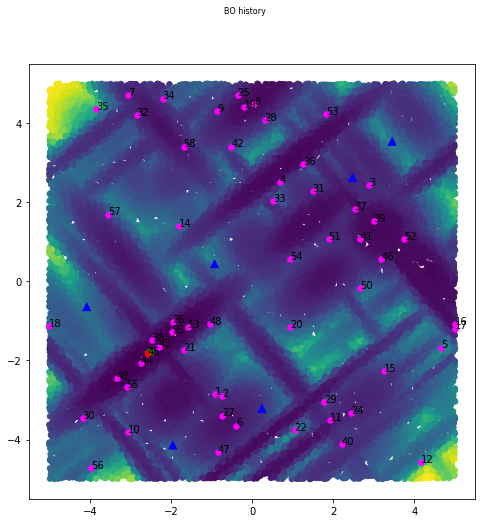

In [18]:
plt.rcParams["figure.figsize"] = (8, 8)
lhs_s_precision, lhs_s_regret, lhs_s_history = compute_all_for(generate_lhs, n=1)
print(f'LHS precision: {lhs_s_precision}, LHS regret: {lhs_s_regret}')
plot_ei_performance(obj_func, samples, values, lhs_s_history[0]['bo'], lhs_s_history[0], marker_size=30)

# Uniform

In [17]:
def generate_uniform():
  return np.random.uniform(-5, 5, (doe_size, 2))

In [ ]:
uniform_precision, uniform_regret, uniform_history = compute_all_for(generate_uniform, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Uniform precision: [3129.315050922313], Uniform regret: [1.0335847153253894]


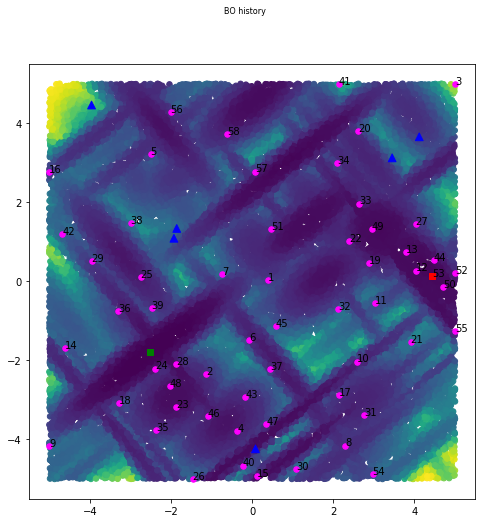

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
u_s_precision, u_s_regret, u_s_history = compute_all_for(generate_uniform, n=1)
print(f'Uniform precision: {u_s_precision}, Uniform regret: {u_s_regret}')
plot_ei_performance(obj_func, samples, values, u_s_history[0]['bo'], u_s_history[0], marker_size=30)

# Sobol

In [20]:
def generate_sobol():
  return Sobol(dim).random(doe_size) * 10 - 5

In [ ]:
sobol_precision, sobol_regret, sobol_history = compute_all_for(generate_sobol, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Sobol precision: [2969.0527432411386], Sobol regret: [8.722107978798022e-05]


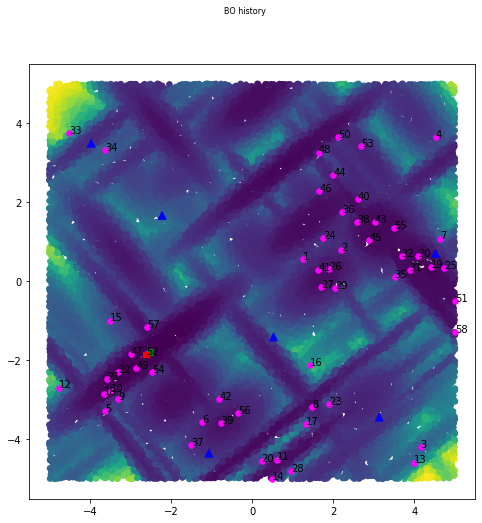

In [22]:
plt.rcParams["figure.figsize"] = (8, 8)
sobol_s_precision, sobol_s_regret, sobol_s_history = compute_all_for(generate_sobol, n=1)
print(f'Sobol precision: {sobol_s_precision}, Sobol regret: {sobol_s_regret}')
plot_ei_performance(obj_func, samples, values, sobol_s_history[0]['bo'], sobol_s_history[0], marker_size=30)

# Halton

In [23]:
def generate_halton():
  return Halton(dim).random(doe_size) * 10 - 5

In [ ]:
halton_precision, halton_regret, halton_history = compute_all_for(generate_halton, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Halton precision: [3046.8338809311285], Halton regret: [0.012968142690006346]


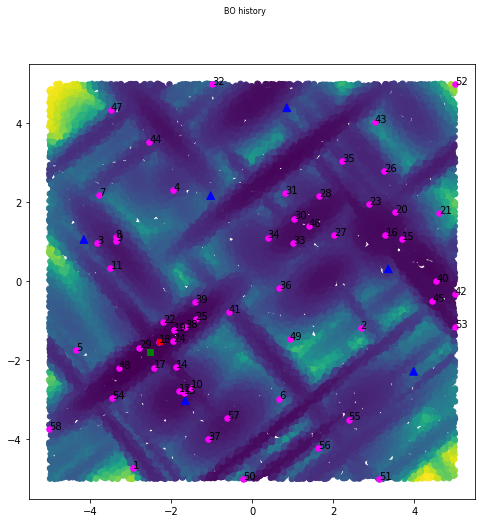

In [25]:
plt.rcParams["figure.figsize"] = (8, 8)
halton_s_precision, halton_s_regret, halton_s_history = compute_all_for(generate_halton, n=1)
print(f'Halton precision: {halton_s_precision}, Halton regret: {halton_s_regret}')
plot_ei_performance(obj_func, samples, values, halton_s_history[0]['bo'], halton_s_history[0], marker_size=30)

# Cumulative

In [ ]:
all_history = (lhs_history, uniform_history, sobol_history, halton_history)
all_titles = ("lhs", "uniform", "sobol", "halton")

Text(0.5, 1.0, 'Regret')

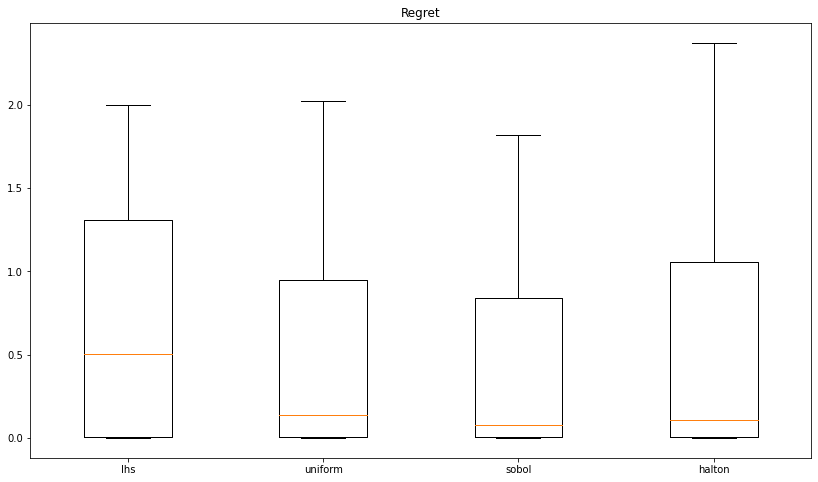

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.concatenate([result['regret'] for result in history]) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Regret')

Text(0.5, 1.0, 'Precision')

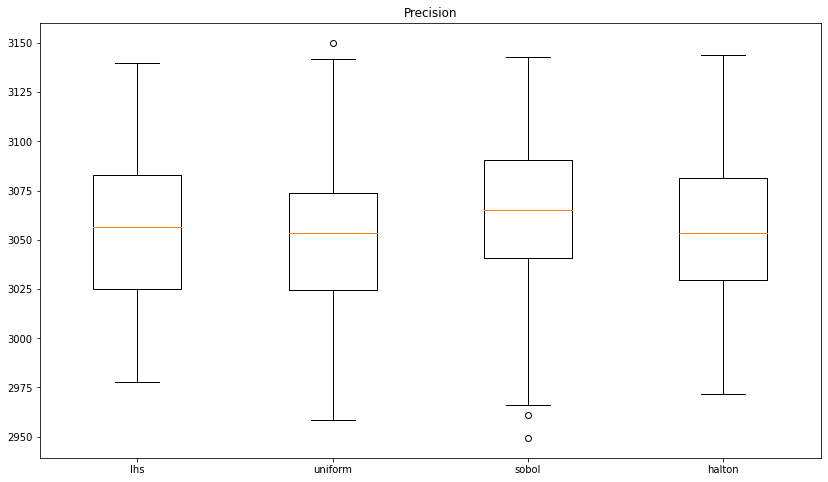

In [ ]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[result['precision'] for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Precision')